In [4]:
pip install mplfinance

     |████████████████████████████████| 70 kB 3.1 MB/s 


In [9]:
pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 4.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import datetime as dt
import mplfinance as mpf
sns.set()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#Load Data
company = 'FB'

start = dt.datetime(2022, 1, 1)
end = dt.datetime.now()
#using 14years data
df = web.DataReader(company, 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-01-03,341.079987,337.190002,338.299988,338.540009,14537900,338.540009
2022-01-04,343.089996,331.869995,339.950012,336.529999,15998000,336.529999
2022-01-05,335.760010,323.839996,333.019989,324.170013,20564500,324.170013
2022-01-06,339.170013,322.720001,322.820007,332.459991,27962800,332.459991
2022-01-07,337.000000,328.880005,332.739990,331.790009,14722000,331.790009


In [23]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
Date,,,,
2022-01-03,0.0,338.540009,NaN,NaN
2022-01-04,0.0,336.529999,NaN,NaN
2022-01-05,0.0,324.170013,NaN,NaN
2022-01-06,0.0,332.459991,NaN,NaN
2022-01-07,0.0,331.790009,NaN,NaN
...,...,...,...,...
2022-03-29,-1.0,229.860001,223.589996,211.490005
2022-03-30,0.0,227.850006,229.860001,211.490005
2022-03-31,0.0,222.360001,229.860001,213.460007


In [24]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 50000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [25]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 10: buy 1 units at price 318.149994, total balance 49681.850006
day 12: buy 1 units at price 316.559998, total balance 49365.290009
day 13: buy 1 units at price 303.170013, total balance 49062.119995
day 15: buy 1 units at price 300.149994, total balance 48761.970001
day 16: buy 1 units at price 294.630005, total balance 48467.339996
day 20, sell 1 units at price 319.000000, investment 8.271389 %, total balance 48786.339996,
day 21, sell 1 units at price 323.000000, investment 9.629024 %, total balance 49109.339996,
day 22: buy 1 units at price 237.759995, total balance 48871.580002
day 23: buy 1 units at price 237.089996, total balance 48634.490005
day 24: buy 1 units at price 224.910004, total balance 48409.580002
day 25: buy 1 units at price 220.179993, total balance 48189.400009
day 28: buy 1 units at price 219.550003, total balance 47969.850006
day 29: buy 1 units at price 217.699997, total balance 47752.150009
day 31: buy 1 units at price 216.539993, total balance 47535.61001

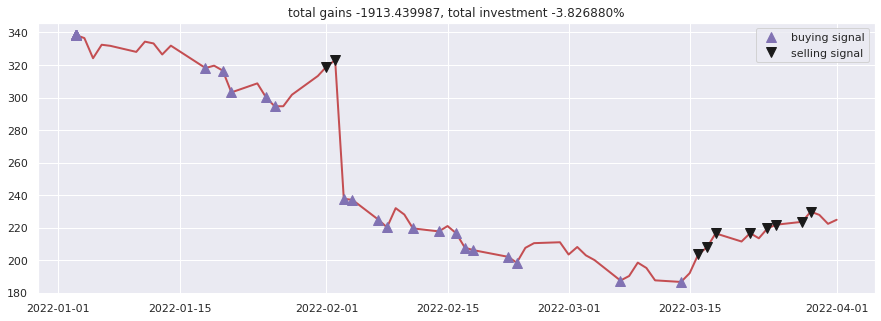

In [26]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()